In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt

## Calibrating the Heston Model: Maximum Likelihood Estimation

See Aït-Sahalia and Kimmel (2007).  The basic idea is to expand the log-likelihood function to the first order, and obtain the coefficients by forcing the expansion to satisfy to order 1 the forward and backward Fokker-Planck-Kolmogorov equations.  For more technical details, see Aït-Sahalia (2001).

In [2]:
df_sp500 = pd.read_csv("data/sp500.csv", index_col=0)
df_sp500.index.name = 'Date'
df_vix = pd.read_csv("data/vix.csv", index_col=0)
df = df_sp500.join(df_vix, on='Date', how='inner')
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df = df[['spindx', 'vix']]

df.head()

,spindx,vix
Date,,
1990-01-02,359.69,17.24
1990-01-03,358.76,18.19
1990-01-04,355.67,19.22
1990-01-05,352.20,20.11
1990-01-08,353.79,20.26


<AxesSubplot:xlabel='Date'>

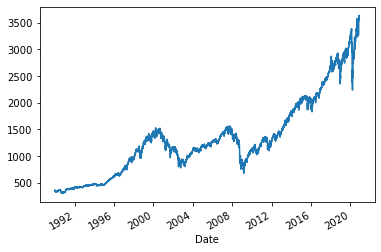

In [3]:
df['spindx'].plot()

<AxesSubplot:xlabel='Date'>

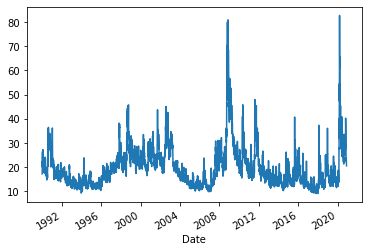

In [4]:
df['vix'].plot()

In [5]:
df.columns = ['s', 'Y']
df['s'] = np.log(df['s'])
df['Y'] = (df['Y'] / 100) ** 2

In [6]:
df.head(3)

,s,Y
Date,,
1990-01-02,5.885243,0.029722
1990-01-03,5.882654,0.033088
1990-01-04,5.874003,0.036941


In [7]:
df.tail(3)

,s,Y
Date,,
2020-11-25,8.196892,0.045156
2020-11-27,8.199286,0.043431
2020-11-30,8.194679,0.042312


In [8]:
df['lag_s'], df['lag_Y'] = df['s'].shift(1), df['Y'].shift(1)
df = df.dropna()

In [9]:
df.head(3)

,s,Y,lag_s,lag_Y
Date,,,,
1990-01-03,5.882654,0.033088,5.885243,0.029722
1990-01-04,5.874003,0.036941,5.882654,0.033088
1990-01-05,5.864199,0.040441,5.874003,0.036941


<AxesSubplot:xlabel='Date'>

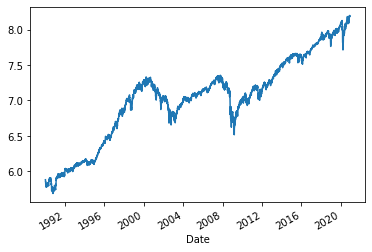

In [10]:
df['s'].plot()

<AxesSubplot:xlabel='Date'>

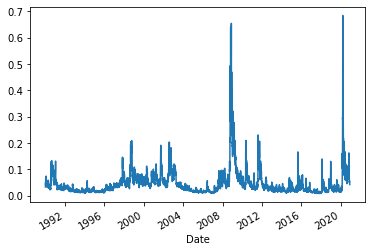

In [11]:
df['Y'].plot()

Our goal is to estimate $\theta$ with maximum likelihood.  For Heston model, the 1st-order expansion of log-likelihood function is given by
$$
\mathcal{l}_X^{(1)}(\Delta, x | x_0; \theta) = -\ln(2\pi\Delta) - D_v(x; \theta) + \Delta^{-1} C_X^{(-1)}(x | x_0; \theta) + C_X^{(0)}(x | x_0; \theta) + \Delta C_X^{(1)}(x | x_0; \theta)
$$
where $\theta = [\kappa; \gamma; \sigma; \rho; \lambda_1; \lambda_2]^\intercal$.  Define $x_1 = s := \ln S$, $x_2 = Y$, and the indirect variables as
$$
\begin{cases}
    \kappa' &= \kappa + \lambda_2 \sigma \\
    \gamma' &= \left( \frac{\kappa}{\kappa + \lambda_2 \sigma} \right) \gamma \\
    a_1 &= r - d \\
    a_2 &= \kappa'\gamma' \\
    b_1 &= \rho \lambda_2 + (1 - \rho^2)\lambda_1 - \frac{1}{2} \\
    b_2 &= \lambda_2 \sigma - \kappa'.
\end{cases}
$$
We have
$$
\begin{split}
    D_v(x; \theta) &= &\frac{1}{2} \ln\left(\det[v(x;\theta)]\right) = \frac{1}{2}\ln((1-\rho^2)\sigma^\color{red}{2}  x_2^\color{red}{2}), \\
    C_X^{(-1)}(x | x_0; \theta) &= 
    &-\frac{(x_2 - x_{20})^2 - 2\rho\sigma(x_2 - x_{20})(x_1 - x_{10}) + \sigma^2(x_1 - x_{10})^2}{2(1 - \rho^2)\sigma^2x_{20}} \\
    & &+ \frac{(x_2 - x_{20})^3}{4(1-\rho^2)\sigma^2x_{20}^2} - \frac{\rho(x_2 - x_{20})^2(x_1 - x_{10})}{2(1 - \rho^2)\sigma x_{20}^2} \\
    & &+ \frac{(x_2 - x_{20})(x_1 - x_{10})^2}{4(1 - \rho^2)x_{20}^2} + \frac{(7\rho - 8\rho^3)(x_2 - x_{20})^3(x_1 - x_{10})}{24(1 - \rho^2)^2\sigma x_{20}^3} \\
    & &- \frac{(7 - 10\rho^2)(x_2 - x_{20})^2(x_1 - x_{10})^2}{48(1 - \rho^2)^2 x_{20}^3} \\
    & &- \frac{\rho\sigma(x_2 - x_{20})(x_1 - x_{10})^3}{24(1 - \rho^2)^2 x_{20}^3} + \frac{\sigma^2(x_1 - x_{10})^4}{96(1 - \rho^2)^2 x_{20}^3} - \frac{(15 - 16\rho^2)(x_2 - x_{20})^4}{96(1-\rho^2)^2\sigma^2x_{20}^3}, \\
    C_X^{(0)}(x | x_0; \theta) &= 
    &\frac{(x_2 - x_{20})(x_{20}b_2 - \rho\sigma x_{20}b_1 - \rho\sigma a_1 + a_2)}{(1 - \rho^2)\sigma^2x_{20}} \\
    & &- \frac{(x_1 - x_{10})(\rho x_{20}b_2 - \sigma x_{20}b_1 - \sigma a_1 + \rho a_2)}{(1 - \rho^2)\sigma x_{20}} \\
    & &- \frac{\sigma^2(x_1 - x_{10})^2}{24(1-\rho^2)x_{20}^2} - \frac{(x_2 - x_{20})^2(\sigma(\sigma - 12\rho a_1) + 12 a_2)}{24 (1-\rho^2)\sigma^2x_{20}^2} \\
    & &+ \frac{(x_2 - x_{20})(x_1 - x_{10})(\rho\sigma^2 - 6\sigma a_1 + 6\rho a_2)}{12\sigma x_{20}^2(1 - \rho^2)}, \\
    C_X^{(1)}(x | x_0; \theta) &= 
    & \frac{\rho\sigma a_2b_1 + \rho\sigma a_1b_2 - \sigma^2 a_1b_1 - a_2b_2}{(1 - \rho^2)\sigma^2} + \frac{(2\rho\sigma b_1b_2 - \sigma^2b_1^2 - b_2^2)x_{20}}{2(1 - \rho^2)\sigma^2} \\
    & &- \frac{\sigma^4 - \rho^2\sigma^4 + 6\sigma^2a_1^2 - 6\sigma^2 a_2 + 6\rho^2\sigma^2a_2 - 12\rho\sigma a_1a_2 + 6a_2^2}{12(1 - \rho^2)\sigma^2 x_{20}}.
\end{split}
$$

In [12]:
# prepare functions
def coefs(x, x0, theta, r, d):
    # unpack theta
    kappa, gamma, sigma, rho, lambda_1, lambda_2 = theta
    
    # generate indirect variables
    kappa_p = kappa + lambda_2 * sigma
    gamma_p = kappa / (kappa + lambda_2 * sigma) * gamma
    a1 = r - d
    a2 = kappa_p * gamma_p
    b1 = rho * lambda_2 + (1 - rho ** 2) * lambda_1 - 1/2
    b2 = lambda_2 * sigma - kappa_p
    
    # calculate coefficients
    ## some shorthands
    diff_s = x.iloc[:, 0] - x0.iloc[:, 0]
    diff_Y = x.iloc[:, 1] - x0.iloc[:, 1]
    eta = 1 - rho**2
    x20 = x0.iloc[:, 1]
    
    c_neg = -(diff_Y**2 - 2*rho*sigma*diff_Y*diff_s + (sigma*diff_s)**2)/(2*eta * sigma**2 * x20) \
            + diff_Y**3/(4*eta*(sigma*x20)**2) - rho*diff_Y**2 * diff_s/(2*eta * sigma * x20**2) \
            + diff_Y*diff_s**2/(4*eta * x20**2) + (7*rho - 8*rho**3) * diff_Y**3 * diff_s/(24* eta**2 * sigma * x20**3) \
            - (7 - 10*rho**2) * (diff_Y*diff_s)**2/(48 * eta**2 * x20**3) \
            - rho*sigma*diff_Y*diff_s**3/(24 * eta**2 * x20**3) + sigma**2 * diff_s**4/(96 * eta**2 * x20**3) \
            - (15 - 16*rho**2)*diff_Y**4/(96 * eta**2 * sigma**2 * x20**3)
    
    c_0 =   diff_Y * (x20*b2 - rho*sigma*x20*b1 - rho*sigma*a1 + a2)/(eta* sigma**2 * x20) \
            - diff_s * (rho*x20*b2 - sigma*x20*b1 - sigma*a1 + rho*a2)/(eta*sigma*x20) \
            - (sigma*diff_s)**2/(24*eta*x20**2) - diff_Y**2 * (sigma*(sigma - 12*rho*a1) + 12*a2)/(24*eta* (sigma*x20)**2) \
            + diff_Y*diff_s*(rho*sigma**2 - 6*sigma*a1 + 6*rho*a2)/(12*sigma * x20**2 * eta)
    
    c_1 =   (rho*sigma*a2*b1 + rho*sigma*a1*b2 - sigma**2 * a1*b1 - a2*b2)/(eta * sigma**2) \
            + (2*rho*sigma*b1*b2 - (sigma*b1)**2 - b2**2) * x20 / (2*eta*sigma**2) \
            - (sigma**4 - rho**2 * sigma**4 + 6*(sigma*a1)**2 - 6 * sigma**2 * a2 + 6*(rho*sigma)**2 * a2 - 12*rho*sigma*a1*a2 + 6*a2**2)/(12*eta * sigma**2 * x20)
    
    return c_neg, c_0, c_1

In [13]:
def neg_log_likelihood(theta, df, delta, r, d):
    # unpack parameters
    kappa, gamma, sigma, rho, lambda_1, lambda_2 = theta
    x_vec = df.iloc[:, [0, 1]]
    x0_vec = df.iloc[:, [2, 3]]
    
    # Note there's an error here in paper p.447: sigma and x2 in the determinant term should be squared
    # You can try logdet without squared term, but the estimated kappa will be around 7,
    # which is different from 5 as was reported
    # I correct the error here
    logdet = 1/2 * np.log((1 - rho**2) * sigma**2 * x_vec.iloc[:, 1]**2)
    
    c_neg, c_0, c_1 = coefs(x_vec, x0_vec, theta, r, d)
    return -np.sum(-np.log(2*np.pi*delta) - logdet + 1/delta * c_neg + c_0 + delta * c_1)

In [14]:
df.mean()

s        7.022791
Y        0.044485
lag_s    7.022496
lag_Y    0.044483
dtype: float64

In [15]:
# try to replicate table 6 columns (1)-(3) in the paper
df = df['1990-01-02':'2003-09-30']

In [16]:
# test the negative log likelihood function
theta = (3., df.mean()['Y'], .25, 0, 4.0, 4.0)
delta = 1/252
r = d = 0
neg_log_likelihood(theta, df, delta, r, d)

-23403.577564824634

### Results from Different Optimization Algorithms

#### Nelder-Mead

In [17]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, -0.7, 4.0, 4.0)
delta = 1/252
r = d = 0
res = minimize(neg_log_likelihood, theta,
               method='Nelder-Mead',
               args=(df, delta, r, d), 
#                bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               options={'disp' : True})

Optimization terminated successfully.
         Current function value: -25637.737207
         Iterations: 424
         Function evaluations: 661


In [18]:
res.x

array([ 5.15504496,  0.045654  ,  0.47807731, -0.77151435, -5.14891231,
       -5.45707851])

#### BFGS

In [19]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, -0.7, 4.0, 4.0)
delta = 1/252
r = d = 0
res = minimize(neg_log_likelihood, theta,
               method='BFGS',
               args=(df, delta, r, d), 
#                bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               options={'disp' : True})

/Users/hylei/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         Current function value: -25637.737207
         Iterations: 23
         Function evaluations: 752
         Gradient evaluations: 105


In [20]:
res.x

array([ 5.15506424,  0.04565384,  0.4780774 , -0.7715144 ,  5.88746669,
        0.3329573 ])

#### CG

In [21]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, -0.7, 4.0, 4.0)
delta = 1/252
r = d = 0
res = minimize(neg_log_likelihood, theta,
               method='CG',
               args=(df, delta, r, d), 
#                bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               options={'disp' : True})

/Users/hylei/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         Current function value: -25637.737206
         Iterations: 259
         Function evaluations: 3904
         Gradient evaluations: 556


In [22]:
res.x

array([ 5.15469265,  0.0456567 ,  0.47807724, -0.77151422,  5.91943919,
        0.35078923])

#### Constrained Optimization

We set the following constraints:
$$
\kappa > 0, \gamma > 0, \sigma > 0, -1 \lt \rho \lt 1, \lambda_1 \in \mathbb{R}, \lambda_2 \in \mathbb{R}.
$$

We also want the parameters to satisfy Feller's condition, $2\kappa'\gamma' = 2\kappa\gamma \geq \sigma^2$.  (It's often disgarded in practice though)

In [23]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, 0, 4.0, 4.0)
delta = 1/252
r = d = 0

con = lambda x: 2 * x[0] * x[1] - x[2] ** 2
nlc = NonlinearConstraint(con, 0, np.inf)

res = minimize(neg_log_likelihood, theta,
               method='trust-constr',
               args=(df, delta, r, d), 
               bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               constraints=nlc,
               options={'disp' : True})

/Users/hylei/opt/miniconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 400, function evaluations: 3269, CG iterations: 1801, optimality: 2.44e-04, constraint violation: 0.00e+00, execution time: 6.9e+01 s.


In [24]:
res.x

array([ 5.15500762,  0.04565449,  0.47807738, -0.77151433,  6.03739361,
        0.41190044])

## Out-of-sample Performance

Let's estimate the parameters for the period from Jan 1, 2000 to Nov 30, 2020.

In [25]:
df_sp500 = pd.read_csv("data/sp500.csv", index_col=0)
df_sp500.index.name = 'Date'
df_vix = pd.read_csv("data/vix.csv", index_col=0)
df = df_sp500.join(df_vix, on='Date', how='inner')
df.index = pd.to_datetime(df.index, format='%Y%m%d')
df = df[['spindx', 'vix']]

df.columns = ['s', 'Y']
df['s'] = np.log(df['s'])
df['Y'] = (df['Y'] / 100) ** 2

df['lag_s'], df['lag_Y'] = df['s'].shift(1), df['Y'].shift(1)
df = df.dropna()

In [26]:
df.tail()

,s,Y,lag_s,lag_Y
Date,,,,
2020-11-23,8.182445,0.051348,8.176825,0.056169
2020-11-24,8.198477,0.046829,8.182445,0.051348
2020-11-25,8.196892,0.045156,8.198477,0.046829
2020-11-27,8.199286,0.043431,8.196892,0.045156
2020-11-30,8.194679,0.042312,8.199286,0.043431


In [27]:
df = df['2000-01-01':'2020-11-30']

#### BFGS

In [28]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, -0.7, 4.0, 4.0)
delta = 1/252
r = d = 0
res = minimize(neg_log_likelihood, theta,
               method='BFGS',
               args=(df, delta, r, d), 
#                bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               options={'disp' : True})

/Users/hylei/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         Current function value: -37145.732774
         Iterations: 37
         Function evaluations: 469
         Gradient evaluations: 67


In [29]:
res.x

array([  7.32504562,   0.04768608,   0.71516881,  -0.78079472,
       -14.69536983,  -9.14513363])

#### CG

In [30]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, -0.7, 4.0, 4.0)
delta = 1/252
r = d = 0
res = minimize(neg_log_likelihood, theta,
               method='CG',
               args=(df, delta, r, d), 
#                bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               options={'disp' : True})

/Users/hylei/opt/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


         Current function value: -37145.732773
         Iterations: 257
         Function evaluations: 3458
         Gradient evaluations: 494


In [31]:
res.x

array([ 7.32399746,  0.04769188,  0.71516858, -0.78079482,  5.52085613,
        0.96378381])

#### Constrained Optimization

In [32]:
# kappa, gamma, sigma, rho, lambda1, lambda2
theta = (3., df['Y'].mean(), .25, 0, 4.0, 4.0)
delta = 1/252
r = d = 0

con = lambda x: 2 * x[0] * x[1] - x[2] ** 2
nlc = NonlinearConstraint(con, 0, np.inf)

res = minimize(neg_log_likelihood, theta,
               method='trust-constr',
               args=(df, delta, r, d), 
               bounds=((0, np.inf), (0, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf)),
               constraints=nlc,
               options={'disp' : True})

/Users/hylei/opt/miniconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 162, function evaluations: 959, CG iterations: 443, optimality: 9.77e-04, constraint violation: 0.00e+00, execution time: 1.8e+01 s.


In [33]:
res.x

array([ 7.32489919,  0.04768734,  0.71516906, -0.78079487,  5.52381703,
        0.96400839])